In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
import os
import glob

set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [3]:
nueva_ruta = '/media/erick/TOSHIBA EXT/results_06032025/weak_allee/mu_0'
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = 1

os.chdir(nueva_ruta)

In [4]:
# Función para cargar y graficar archivos
def plot_correlation(files, title):
    plt.figure(figsize=(8, 6))
    
    for file_name in files:
        try:
            data = np.loadtxt(file_name)
            x, y = data[:, 0], data[:, 1]
            plt.plot(x, y, linestyle='-', label=file_name.split('_')[-2] + '-' + file_name.split('_')[-1].split('.')[0])
        except Exception as e:
            print(f"Error al cargar {file_name}: {e}")

    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# Patrones de nombres para los archivos
cross_corr_patterns = ["corr_length_real_inverse_c_s.txt",
                       "corr_length_real_inverse_c_i.txt",
                       "corr_length_real_inverse_s_i.txt"]
auto_corr_patterns = ["corr_length_real_inverse_c_c.txt",
                      "corr_length_real_inverse_s_s.txt",
                      "corr_length_real_inverse_i_i.txt"]


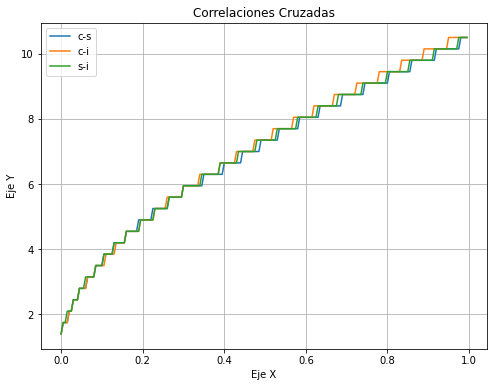

In [9]:

# Graficar correlaciones cruzadas
plot_correlation(cross_corr_patterns, "Correlaciones Cruzadas")

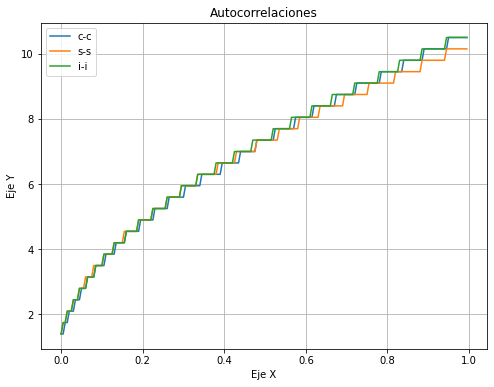

In [14]:
# Graficar autocorrelaciones
plot_correlation(auto_corr_patterns, "Autocorrelaciones")